# Credit Card Approval Using Machine Learning

In [18]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns

In [17]:
import cufflinks as cf
# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

In [5]:
cca =  pd.read_csv('credit_card_approval.csv')
cca.sample(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
3958,5008875,F,N,Y,2+ children,126000.0,Higher education,Married,House / apartment,-12411,-1773,1,0,0,1,Managers,-13,C,0
151053,5105007,M,Y,Y,1 children,216000.0,Secondary / secondary special,Married,Rented apartment,-17051,-1457,1,0,0,0,Laborers,-13,C,0
167457,5054209,M,Y,N,2+ children,171000.0,Secondary / secondary special,Married,With parents,-11301,-2250,1,1,0,0,Laborers,-11,C,0
493513,5143485,M,N,Y,1 children,157500.0,Secondary / secondary special,Married,House / apartment,-11935,-1200,1,0,0,0,Drivers,-50,0,0
202244,5065784,F,N,Y,No children,157500.0,Secondary / secondary special,Married,House / apartment,-17343,-938,1,0,0,0,Sales staff,-23,C,0
76334,5021420,F,N,Y,No children,270000.0,Secondary / secondary special,Married,House / apartment,-20066,-3988,1,1,1,0,Private service staff,-17,C,0
493579,5065579,F,N,Y,2+ children,144000.0,Secondary / secondary special,Married,House / apartment,-11147,-262,1,0,0,0,Cleaning staff,0,C,0
324141,5009157,F,N,N,No children,180000.0,Secondary / secondary special,Married,House / apartment,-19575,-2901,1,0,0,0,Sales staff,-40,C,0
385711,5041609,M,Y,Y,No children,270000.0,Secondary / secondary special,Married,House / apartment,-12257,-1463,1,0,0,0,Laborers,-15,C,0
101035,5061835,M,Y,Y,No children,180000.0,Lower secondary,Married,House / apartment,-16352,-3972,1,1,1,0,Laborers,-15,C,0


In [14]:
cca.dtypes

ID                       int64
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN            object
AMT_INCOME_TOTAL       float64
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
JOB                     object
BEGIN_MONTHS             int64
STATUS                  object
TARGET                   int64
dtype: object

In [13]:
cca['CODE_GENDER'].replace('M',0,inplace=True)
cca['CODE_GENDER'].replace('F',1,inplace=True)
cca['FLAG_OWN_CAR'].replace('Y',0,inplace=True)
cca['FLAG_OWN_CAR'].replace('N',1,inplace=True)
cca['FLAG_OWN_REALTY'].replace('Y',0,inplace=True)
cca['FLAG_OWN_REALTY'].replace('N',1,inplace=True)

In [7]:
columns = []
for n in cca.columns:
    columns.append(n)

In [29]:
for n in columns:  
    print(n)
    print(cca[n].unique())
    for i in cca[n].isna():
        if i == True:
            print("AHAAAA")
    print('\n \n')

ID
[5065438 5142753 5111146 ... 5090938 5116980 5045855]

 

CODE_GENDER
[1 0]

 

FLAG_OWN_CAR
[0 1]

 

FLAG_OWN_REALTY
[1 0]

 

CNT_CHILDREN
['2+ children' 'No children' '1 children']

 

AMT_INCOME_TOTAL
[ 270000.    81000.   112500.   139500.   144000.   180000.   405000.
  135000.    99000.   103500.   225000.   171000.   202500.    67500.
  121500.   560250.    74250.    90000.   324000.   391500.   292500.
  229500.   157500.    94500.   148500.   450000.    45000.   382500.
  126000.   315000.   306000.   247500.   675000.    36000.   562500.
  337500.   360000.   211500.   119250.   216000.   122400.   220500.
  193500.   427500.    63000.    76500.   472500.   495000.    95850.
   54000.   459000.   540000.   265500.   146250.   108000.   283500.
  310500.   130500.   252000.   234000.   198000.   166500.   256500.
  153000.   207000.   607500.   468000.    72000.   279000.   238500.
   85500.   173250.    62653.5  445500.   117000.   184500.   261000.
  189000.   162000.  

In [9]:
cca.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
JOB                    0
BEGIN_MONTHS           0
STATUS                 0
TARGET                 0
dtype: int64

<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

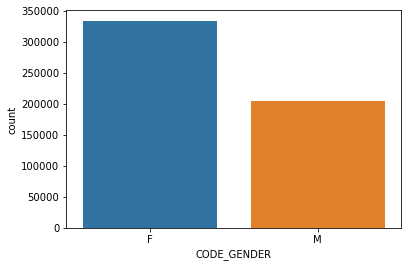

In [10]:
sns.countplot(x='CODE_GENDER',data=cca)

[Text(0.5, 0, 'ID'),
 Text(1.5, 0, 'CODE_GENDER'),
 Text(2.5, 0, 'FLAG_OWN_CAR'),
 Text(3.5, 0, 'FLAG_OWN_REALTY'),
 Text(4.5, 0, 'AMT_INCOME_TOTAL'),
 Text(5.5, 0, 'DAYS_BIRTH'),
 Text(6.5, 0, 'DAYS_EMPLOYED'),
 Text(7.5, 0, 'FLAG_MOBIL'),
 Text(8.5, 0, 'FLAG_WORK_PHONE'),
 Text(9.5, 0, 'FLAG_PHONE'),
 Text(10.5, 0, 'FLAG_EMAIL'),
 Text(11.5, 0, 'BEGIN_MONTHS'),
 Text(12.5, 0, 'TARGET')]

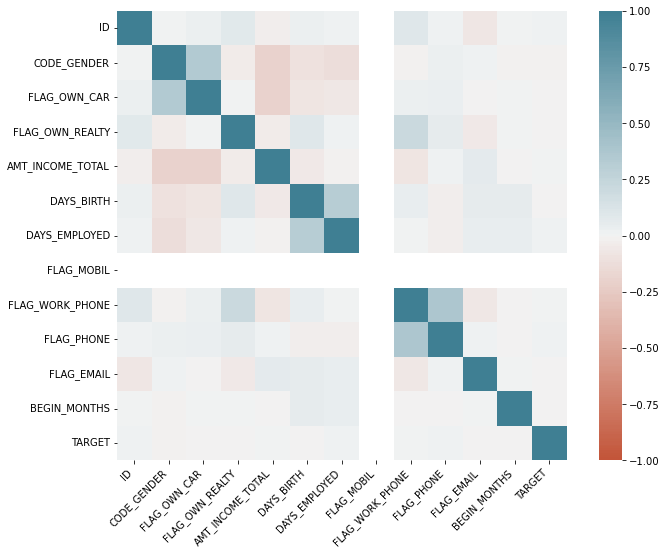

In [15]:
import matplotlib.pyplot as plt
a4_dims = (11.7, 8.27)
#df = mylib.load_data()
fig, ax = plt.subplots(figsize=a4_dims)
corr = cca.corr()
ax = sns.heatmap(corr,ax=ax,  
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [16]:
cca.corr()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,BEGIN_MONTHS,TARGET
ID,1.000000,0.004041,0.025431,0.085132,-0.024915,0.029609,0.014325,NaN,0.098981,0.014584,-0.072886,0.004673,0.016717
CODE_GENDER,0.004041,1.000000,0.346480,-0.043079,-0.191443,-0.107791,-0.131611,NaN,-0.015376,0.026068,0.022866,-0.013313,-0.016732
FLAG_OWN_CAR,0.025431,0.346480,1.000000,0.005176,-0.201243,-0.080779,-0.065124,NaN,0.027221,0.032976,-0.005493,0.000517,-0.003076
FLAG_OWN_REALTY,0.085132,-0.043079,0.005176,1.000000,-0.043247,0.095824,0.016816,NaN,0.216011,0.059563,-0.060949,0.005988,-0.005364
AMT_INCOME_TOTAL,-0.024915,-0.191443,-0.201243,-0.043247,1.000000,-0.047838,-0.009500,NaN,-0.078836,0.007914,0.067699,-0.001829,0.002887
DAYS_BIRTH,0.029609,-0.107791,-0.080779,0.095824,-0.047838,1.000000,0.324231,NaN,0.041483,-0.030423,0.055471,0.051247,-0.005401
DAYS_EMPLOYED,0.014325,-0.131611,-0.065124,0.016816,-0.009500,0.324231,1.000000,NaN,0.003695,-0.026980,0.041690,0.044414,0.019230
FLAG_MOBIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_WORK_PHONE,0.098981,-0.015376,0.027221,0.216011,-0.078836,0.041483,0.003695,NaN,1.000000,0.372385,-0.069643,-0.002339,0.004353
FLAG_PHONE,0.014584,0.026068,0.032976,0.059563,0.007914,-0.030423,-0.026980,NaN,0.372385,1.000000,0.014056,-0.007564,0.008663


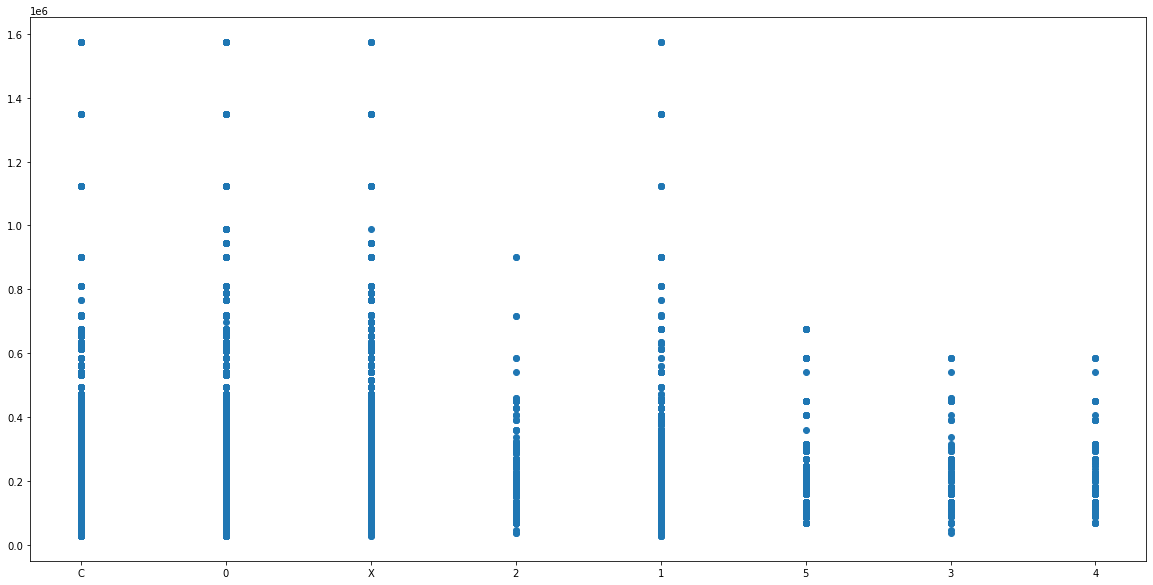

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(cca.STATUS,cca.AMT_INCOME_TOTAL)

<AxesSubplot:>

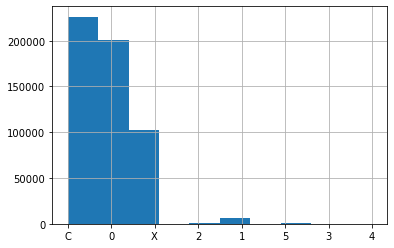

In [23]:
cca.STATUS.hist()

In [25]:
cca_0 = cca[cca['TARGET']==0]
cca_0

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,1,0,1,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,5142753,1,1,1,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,5111146,0,0,0,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,5010310,1,0,0,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,5010835,0,0,0,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537662,5142999,0,0,1,1 children,166500.0,Secondary / secondary special,Married,With parents,-12372,-5401,1,0,1,0,Core staff,-8,0,0
537663,5010773,1,1,0,No children,135000.0,Higher education,Married,With parents,-14160,-4635,1,0,0,0,Sales staff,-8,0,0
537664,5105601,0,1,0,No children,180000.0,Higher education,Married,House / apartment,-24204,-2462,1,0,0,0,Private service staff,-7,0,0
537665,5132833,0,0,1,No children,220500.0,Secondary / secondary special,Married,House / apartment,-22647,-3847,1,0,1,0,Laborers,-1,0,0


In [26]:
cca_1 = cca[cca['TARGET']==1]
cca_1

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
102,5022428,1,1,0,No children,90000.0,Secondary / secondary special,Civil marriage,House / apartment,-16569,-517,1,0,0,0,Laborers,-38,2,1
325,5092251,0,0,0,No children,112500.0,Secondary / secondary special,Married,House / apartment,-17300,-1235,1,0,0,0,Drivers,-44,2,1
380,5029719,1,0,0,1 children,265500.0,Higher education,Married,With parents,-10998,-2514,1,0,0,0,Accountants,-9,2,1
529,5115608,1,1,0,No children,202500.0,Secondary / secondary special,Married,House / apartment,-14523,-3420,1,0,0,0,Core staff,-16,5,1
764,5018498,1,0,0,No children,90000.0,Secondary / secondary special,Married,House / apartment,-18950,-1002,1,1,1,0,Cooking staff,-35,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536562,5096743,1,1,0,No children,180000.0,Lower secondary,Widow,House / apartment,-16803,-2227,1,1,1,0,Cleaning staff,-35,4,1
537065,5096283,0,0,1,No children,135000.0,Secondary / secondary special,Married,House / apartment,-14209,-97,1,0,0,0,Security staff,-34,2,1
537289,5024939,0,1,0,No children,225000.0,Secondary / secondary special,Civil marriage,House / apartment,-12451,-1646,1,0,0,0,Sales staff,-2,2,1
537445,5052884,0,0,0,No children,225000.0,Secondary / secondary special,Married,House / apartment,-17915,-3366,1,0,0,0,Drivers,-30,2,1


<AxesSubplot:xlabel='TARGET', ylabel='count'>

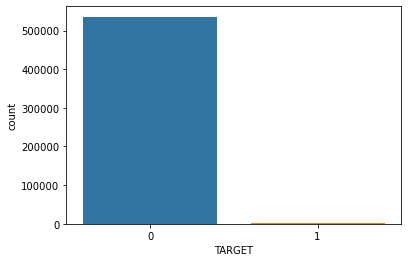

In [28]:
sns.countplot(x='TARGET',data=cca)